In [1]:
# ideas for a source test
import cobra
import pandas as pd

from refinegems.utility.io import load_model

/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


In [2]:
test_model_path = '/Users/brune/Documents/11_Test_Data/test_SPECIMEN/thesis/Kp_std/03_refinement/step4-smoothing/Kp_std_smooth.xml'
test_model = load_model(test_model_path,'cobra')


-----
### Plot the basic analysis

- one model
- collection of models

In [ ]:
# old version of how to plot basic analysis
# will absolutely no longer work since it uses a model and the report is no longer based on it.
def plot_initial_analysis(models: list[libModel]):
    """Creates bar plot of number of entities per Model

    Args:
        - models (list[libModel]): Models loaded with libSBML

    Returns:
        plot: Pandas Barchart
    """
    numbers = pd.DataFrame([initial_analysis(model) for model in models], columns=['model', 'metabolites', 'reactions', 'genes'])
    ax = numbers.set_index('model').plot.bar(y=['metabolites', 'reactions', 'genes'], figsize=(8, 5), cmap='Paired', rot=0)
    # commented is possibility to integrate memote scores
    #numbers.set_index('model').plot(y='Memote score', ax=ax, use_index=False, linestyle=':', secondary_y='Memote score', color='k', marker='D', legend=True)
    #ax.right_ax.set_ylabel('Memote score [%]')
    #ax.right_ax.legend(loc='upper right', bbox_to_anchor=[0.98, 0.9])
    #ax.right_ax.set_ylim([75, 95])
    ax.legend(title=False, loc='upper left', ncol=3, frameon=False)
    ylim = numbers.drop('model', axis=1).max().max() + 200
    ax.set_ylim([0,ylim])
    ax.set_xlabel('')
    ax.tick_params(axis='x',which='both', bottom=False,top=False)
    return ax

In [3]:
from refinegems.classes.reports import ModelInfoReport

rep = ModelInfoReport(test_model)

/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/cobra/core/metabolite.py:129: UserWarning: invalid character '*' found in formula 'HO*'
  warn(f"invalid character '*' found in formula '{self.formula}'")
/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/cobra/core/metabolite.py:129: UserWarning: invalid character '*' found in formula 'C8H14NOS2*'
  warn(f"invalid character '*' found in formula '{self.formula}'")
/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/cobra/core/metabolite.py:129: UserWarning: invalid character '*' found in formula 'HO2*'
  warn(f"invalid character '*' found in formula '{self.formula}'")
/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/cobra/core/metabolite.py:129: UserWarning: invalid character '*' found in formula 'C8H16NOS2*'
  warn(f"invalid character '*' found in formula '{self.formula}'")
/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/cobra/core/metabolite.py:129: UserWarning: invalid

#### Plot for a single report

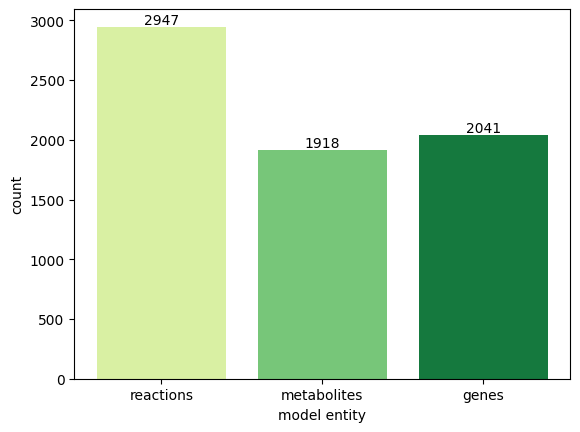

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import warnings

# params
# ------
color_palette = 'YlGn'

# basic settings
# --------------

# create colour gradient
try:
    cmap = matplotlib.colormaps[color_palette]
except ValueError:
    warnings.warn('Unknown color palette, setting it to "YlGn"')
    cmap = matplotlib.colormaps['YlGn']


# 1: plot reacs, metabs and gene counts
# -------------------------------------
fig, ax = plt.subplots()

p = ax.bar(['reactions','metabolites','genes'],
       [rep.reac,rep.meta,rep.gene],
       color=[cmap(0.25),cmap(0.5),cmap(0.8)],
       # edgecolor='black',
       )
ax.bar_label(p, [rep.reac,rep.meta,rep.gene])
ax.set_ylabel('count')
# ax.set_xlabel('model entity')


# 2: plot reacs with gpr
# ----------------------


# 3: plot deadends, orhphand etc. for metabs

# make a nice chart for all



plt.show()

/Users/brune/miniconda3/envs/sprg/lib/python3.10/site-packages/pydantic/_internal/_config.py:322: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


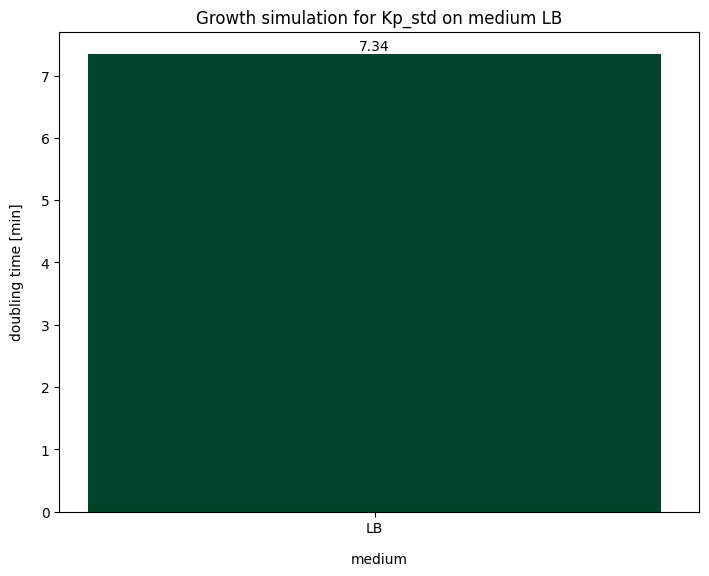

In [1]:
from refinegems.utility.io import load_model
from refinegems.analysis.growth import growth_analysis
from refinegems.classes.medium import load_medium_from_db


test_model_path = '/Users/brune/Documents/11_Test_Data/test_SPECIMEN/thesis/Kp_std/03_refinement/step4-smoothing/Kp_std_smooth.xml'
test_model = load_model(test_model_path,'cobra')

m = load_medium_from_db('LB')
l = load_medium_from_db('SNM3')
test = growth_analysis(test_model,[m], retrieve='plot')

In [5]:
test.plot_growth()

IndexError: Can only plot growth if at least one model and one medium are present.